# 2.3.7 그 외 다른 앙상블

In [1]:
%pip install preamble

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sklearn
from preamble import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, stratify=ym, random_state=42)

cancer = load_breast_cancer()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

2.3.7 그 외 다른 앙상블

- scikit-learn이 제공하는 앙상블 알고리즘

  1) Bagging

  2) AdaBoost

  3) Extra-Trees

  4) Histogram-based Gradient Boosting

### Bagging > 랜덤 포레스트

- bagging: Bootstrap Aggregating

  > 중복을 허용한 랜덤 샘플링으로 만든 훈련세트로 트리를 각기 다르게 학습 = 랜덤포레스트의 특징과 같다

  > 결과는 다수결(분류) 또는 평균(회귀)로 종합

  > 배깅은 특정 모델에 국한하지 않는다: 결정트리, 로지스틱 회귀, SVM 등 사용 

  > 랜덤 포레스트는 배깅 + 결정트리만을 사용하는 특화된 경우


In [ ]:
from sklearn.linear_model import LogisticRegression #  독립된 모델로 로지스틱회귀 모델 사용
from sklearn.ensemble import BaggingClassifier #estimator로 로지스틱 회귀를 선택
bagging = BaggingClassifier(LogisticRegression(solver='liblinear'), n_estimators=100, # 분류기 100개
                            oob_score=True, n_jobs=-1, random_state=42) # oob_score=True는 bootstraping에 포함되지 않은 데이터로 검증
bagging.fit(Xc_train, yc_train)
# Bootstrap 데이터 + 로지스틱 회귀
# 샘플이 조금 바뀌어도
# 가중치 벡터가 거의 동일
# 100개의 로지스틱 회귀 ≈ 거의 같은 모델 100개

BaggingClassifier(estimator=LogisticRegression(solver='liblinear'),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("OOB 샘플의 정확도: {:.3f}".format(bagging.oob_score_)) # bootstrapping에 포함되지 않는 샘플로 평가

훈련 세트 정확도: 0.962
테스트 세트 정확도: 0.958
OOB 샘플의 정확도: 0.948


In [ ]:
from sklearn.tree import DecisionTreeClassifier # 배깅에 결정 트리를 사용
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100,oob_score=True,
                            n_jobs=-1, random_state=42)
bagging.fit(Xm_train, ym_train)
# Bootstrap 데이터 + 결정트리
# 샘플이 달라질 때마다 분기 기준, 트리 구조, 선택되는 특성이 크게 달라짐
# Bagging + DecisionTree = Random Forest의 출발점

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [14]:
print("훈련 세트 정확도: {:.3f}".format(bagging.score(Xm_train, ym_train)))
print("테스트 세트 정확도: {:.3f}".format(bagging.score(Xm_test, ym_test)))
print("OOB 샘플의 정확도: {:.3f}".format(bagging.oob_score_))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.880
OOB 샘플의 정확도: 0.853


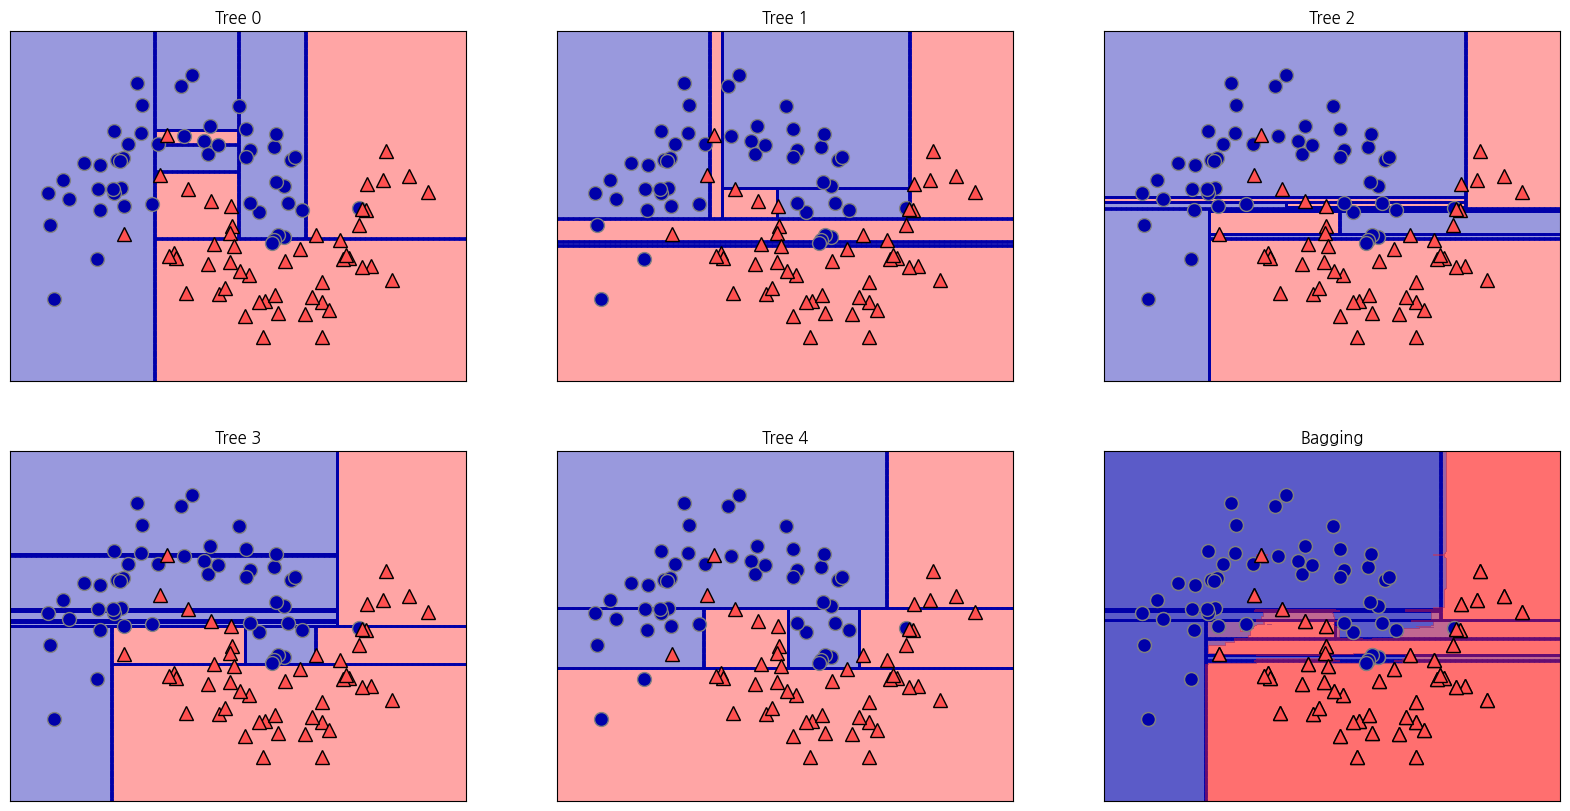

In [15]:
# 배깅 분류기에 있는 결정 트리의 경계와 배깅 결정 경계 - 랜덤 포레스트 결과와 유사

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), bagging.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(bagging, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Bagging")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

In [16]:
# 배깅의 중요 매개변수: max_samples, bootstrap_ = false, max_features, bootstrap_features > 135페이지 첫째 문단

bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100,
                            oob_score=True, n_jobs=-1, random_state=42)
bagging.fit(Xc_train, yc_train)

print("훈련 세트 정확도: {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("OOB 샘플의 정확도: {:.3f}".format(bagging.oob_score_))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.965
OOB 샘플의 정확도: 0.948


### ExtraTrees

- 랜덤 포레스트와 유사, 차이: 후보 특성 중에서 완전 무작위로 분할한 다음에 최적의 분할하는 특성을 찾는다 

  > 노드에서 특성 중 일부를 무작위로 선택 (RandomForest와 동일)

  > 각 특성에 대해 임의의 분할값(예: age < 27.3)을 무작위로 선택(분할 기준도 무작위, 덜 정확하지만 더 빠르고 과적합에 덜 민감)

   => 샘플은 거의 동일 > 대신 분기 과정 자체를 랜덤화

  > 그렇게 생성된 랜덤 분할 중 가장 좋은 것 하나를 선택

- 랜덤 포레스트: 후보 특성은 무작위로 일부 선택 후 > 각 노드에서 후보 특성 중에서 가장 좋은 분할을 하는 특성을 찾는다

  > 전체 특성 중에서 max_features 개수를 랜덤하게 뽑는다

  > 선정된 특성에 대해 지니계수, MSE 감소 등을 계산하여 최적 분할을 주는 특성+ 분할값을 선택한다 

- Extra Trees는 bootstrap 대신 분기 임계값의 무작위화를 통해 트리 간 다양성을 확보하며, 여러 개의 결정트리를 앙상블로 결합한다.

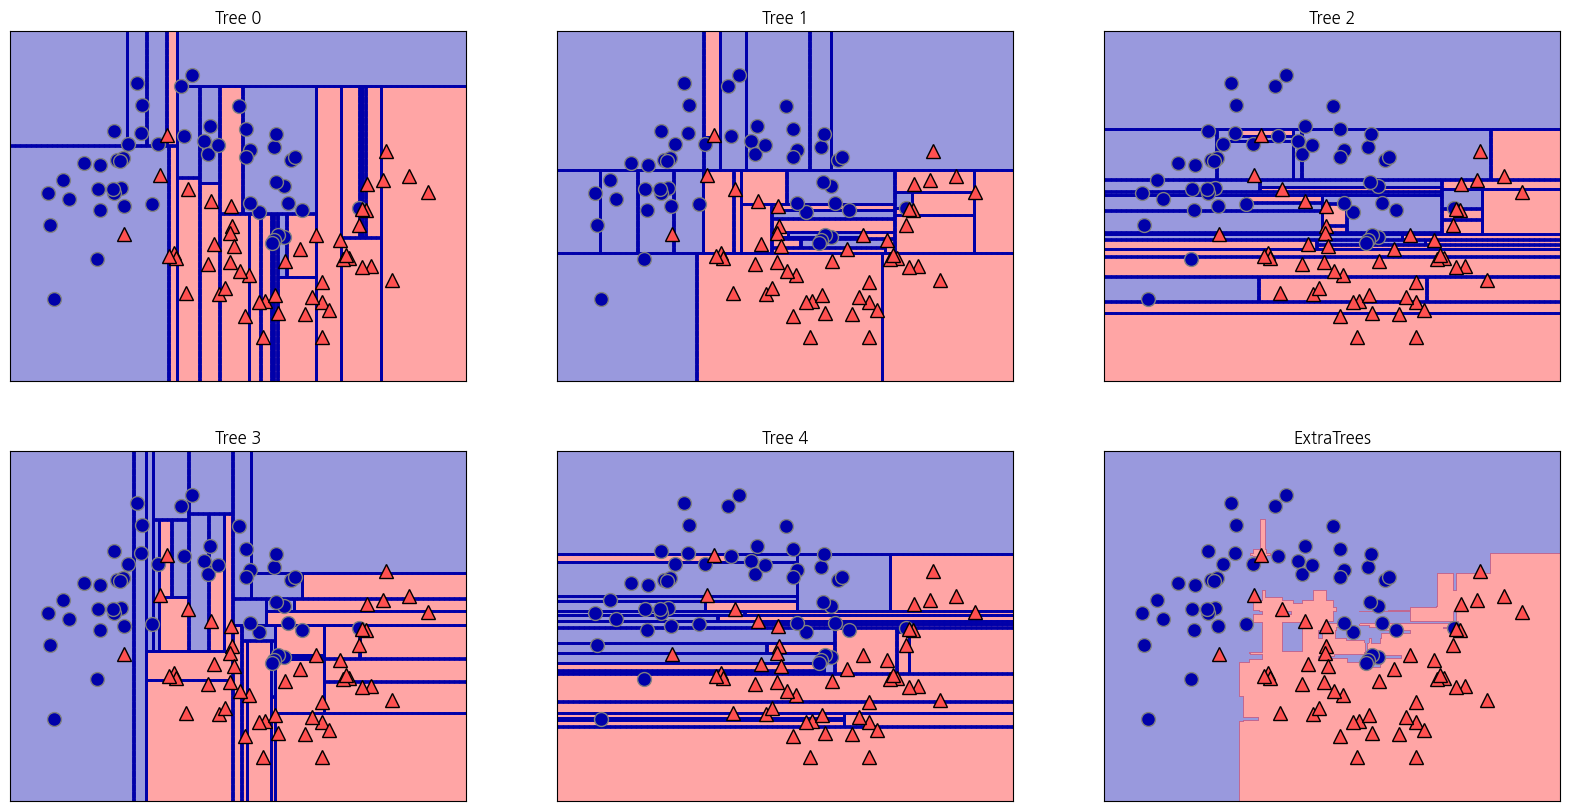

In [17]:
# two_moons 데이터세트에 엑스트라 트리 적용
# 개별 결정 경계가 더 복잡해짐 > 엑스트라 결정 경계는 안정적

from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)
xtree.fit(Xm_train, ym_train)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), xtree.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(xtree, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("ExtraTrees")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

In [18]:
xtree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0)
xtree.fit(Xc_train, yc_train)

print("훈련 세트 정확도: {:.3f}".format(xtree.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(xtree.score(Xc_test, yc_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


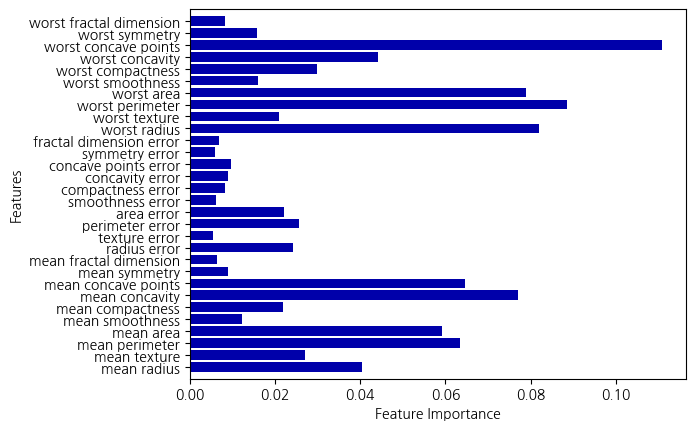

In [19]:
# 엑스트라 트리의 특성 중요도 - 랜덤 포레스트와 비슷

n_features = cancer.data.shape[1]
plt.barh(range(n_features), xtree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)
plt.show()

### AdaBoost
- Adaptive Boosting: Gradient Boosting 차이
  
  > 이전 모델의 잔차를 더 신경 쓴다”는 점은 같지만, 오차를 반영하는 수학적 방식이 완전히 다르다.

  > AdaBoost는 “확률적 가중치(틀린 샘플 강조)” 방식

- Gradient Boosting과 달리 이전의 모델이 잘 못 분류한 샘플에 가중치를 높여서 다음 모델을 훈련

  > 샘플에도 가중치를 주고, 학습한 모델에도 가중치를 준다

  > Gradient Boosting은 “미분(gradient) 기반 최적화” 방식이다.

- AdaBoost의 작동 원리 :

  > 처음에는 모든 샘플의 가중치가 동일 > 예: 100개 샘플이면 각 샘플 가중치 = 1/100

  > 첫 번째 약한 모델 학습 > 이 모델이 틀린 샘플들을 체크

  > 모델의 성능에 따라 “모델 가중치” 계산 > 잘한 모델일수록 나중에 더 중요하게 반영됨

  > 샘플 가중치 업데이트: 틀린 샘플의 가중치 ↑, 맞춘 샘플의 가중치 ↓

  > 다음 모델은 틀린 샘플에 더 집중하게 됨

  > 반복하며 여러 모델을 학습

  > 최종 예측 = 여러 모델의 예측을 “가중 평균” 또는 “가중 투표”

AdaBoost는 틀린 샘플의 가중치를 직접 키워 다음 모델이 더 집중하게 만들고,

Gradient Boosting은 손실 함수의 기울기를 학습하여 모델을 누적 개선한다.

따라서 AdaBoost는 가중치 기반, Gradient Boosting은 미분 기반 방법이다.

[ML] 부스팅 알고리즘(Boosting)이란? AdaBoost, Gradient Boosting, XGBoost, LightGBM의 장단점
gyurili·2025년 1월 26일,https://velog.io/@gyurili/ML-%EB%B6%80%EC%8A%A4%ED%8C%85-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98Boosting%EC%9D%B4%EB%9E%80-AdaBoost-Gradient-Boosting-XGBoost-LightGBM

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


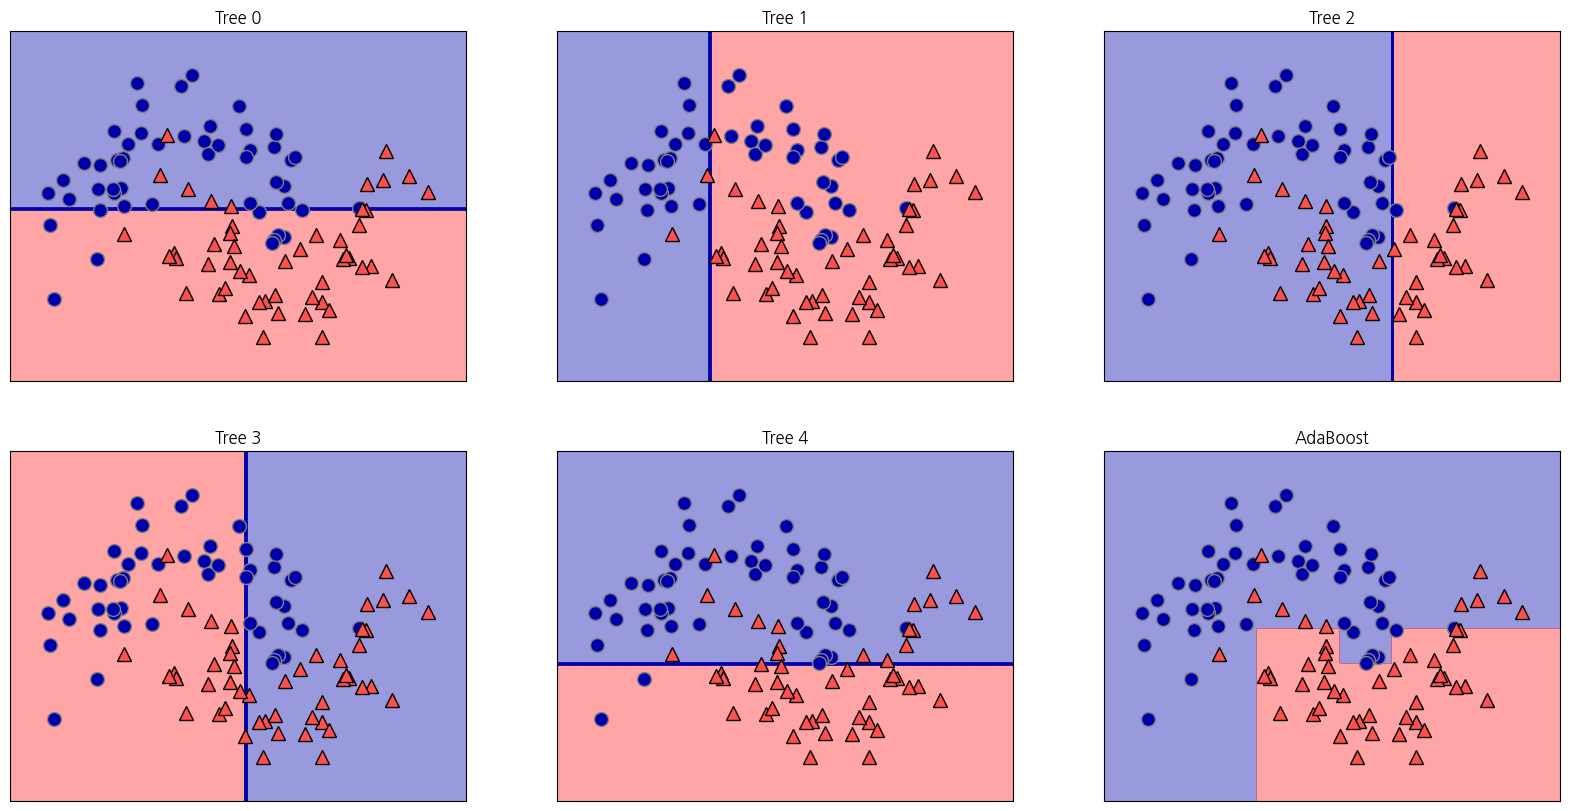

In [20]:
# AdaBoostClassifier는 기본 값으로 DecisionTreeClassifier(max_depth=1)를 사용
# two_moons 데이터세트에 대한 에이다부스트 결정 경계 - 깊이가 1인 결정 트리를 사용

from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42)
ada.fit(Xm_train, ym_train)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), ada.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(ada, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("AdaBoost")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

In [21]:
# cancer 데이터세트에 대한 에이다부스트 적용 > 엑스트라 트리보다 일반화 성능 개선 - 이유: 아주 얕은 트리를 앙상블

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(Xc_train, yc_train)

print("훈련 세트 정확도: {:.3f}".format(ada.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(ada.score(Xc_test, yc_test)))

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.986


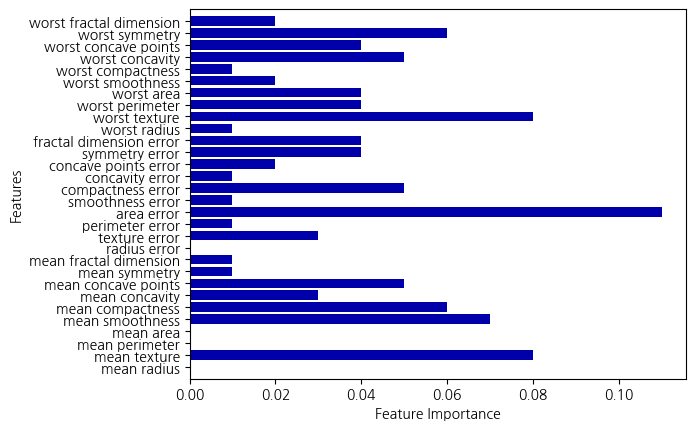

In [22]:
# 에이다부스트의 특성 중요도 > area_error특성을 크게 강조

plt.barh(range(n_features), ada.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)
plt.show()

### HistGradientBoostingClassifier
- 일반적인 트리 기반 학습 방식: 모든 특성에 대해 연속값을 하나씩 다 살펴보며 분할 기준을 찾음

  > Random Forest: 각 트리는 무작위 샘플 + 무작위 특성 사용, 각 노드에서 최적의 분할값을 전체 연속값에서 탐색

  > Gradient Boosting: 모델을 순차적으로 학습, 각 트리는 이전 모델의 잔차(gradient)를 예측, 각 노드에서 모든 분할값을 탐색 (느림)

- 히스토그램 기반 부스팅의 핵심 아이디어: 연속적인 실수값을 고정된 개수의 구간(bin)으로 미리 묶어서, 분할 후보를 간소화

  > Gradient Boosting + 히스토그램 전처리, 수치형 특성을 미리 이산 구간(bin)으로 그룹, 각 bin에 대한 gradient으로 빠르게 최적 분할

  > LightGBM

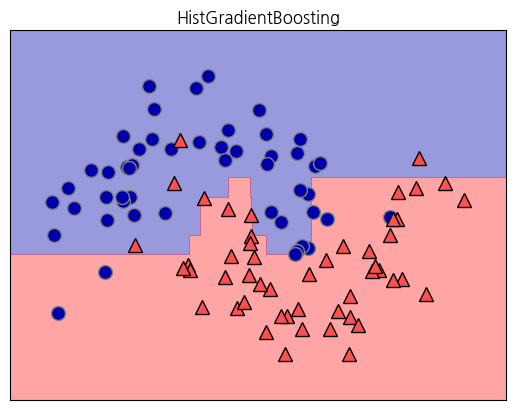

In [25]:
# two_moons 데이터세트에 적용

from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(Xm_train, ym_train)

mglearn.plots.plot_2d_separator(hgb, Xm, fill=True, alpha=.4) #비교적 결정 경계가 복잡하지 않으면서도 중앙에 섞인 두 클래스를 잘 분할 
plt.title("HistGradientBoosting")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.savefig('ch2-fig-histgradientboosting')
plt.show()

In [26]:
# cancer 데이터세트
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(Xc_train, yc_train)

print("훈련 세트 정확도: {:.3f}".format(hgb.score(Xc_train, yc_train)))
print("테스트 세트 정확도: {:.3f}".format(hgb.score(Xc_test, yc_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.979


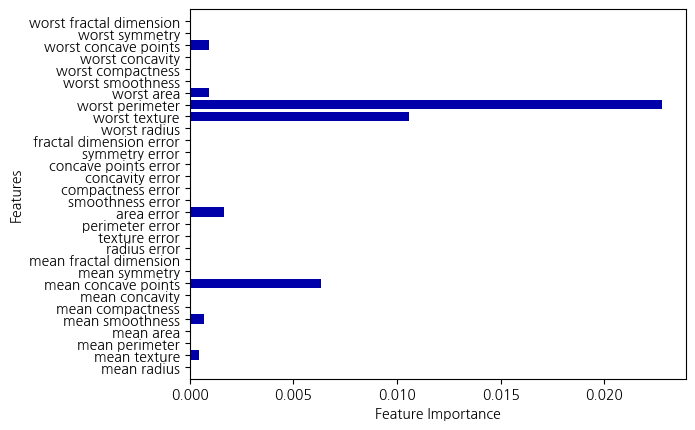

In [27]:
# cancer 데이터세트에 대한 특성 중요도

from sklearn.inspection import permutation_importance

result = permutation_importance(hgb, Xc_train, yc_train,
                               n_repeats=10, random_state=42, n_jobs=-1)

plt.barh(range(n_features), result.importances_mean, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)
plt.show()

### 트리 기반 앙상블 모델의 매개변수
- 143페이지 표2-2